# App Immuni

Stima downloads App Immuni.

> Max Pierini, Alessio Pamovio

Metodo bayesiano [PDF](https://www.maxpierini.it/ncov/immuni-articolo.pdf)

Allegati: dati app [PDF](https://www.maxpierini.it/ncov/immuni-allegato.pdf)

Allegati: test Kolmogorov-Smirnov [PDF](https://www.maxpierini.it/ncov/immuni-ks.pdf)

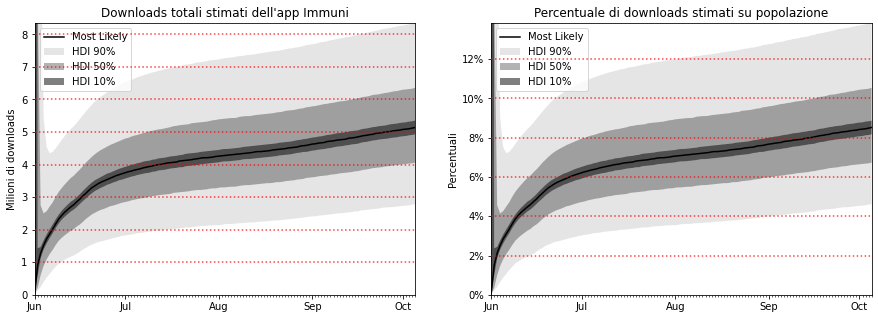

[2020-10-05 16:51:49.096712]: AGGIORNATO al 2020-10-05


In [1]:
import os
from sys import argv
from shutil import copyfile
import time
import datetime as dt

import werkzeug
werkzeug.cached_property = werkzeug.utils.cached_property
from robobrowser import RoboBrowser

import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter

import schedule

DIR = './'

HDIs = [90, 50, 10]

df = pd.read_csv("SummaryInfo.csv", index_col=0)
theta_omega = df.loc["theta_omega"]["Median"]
theta_sigma = df.loc["theta_sigma"]["Median"]

def millions(x, pos):
    'The two args are the value and tick position'
    return f'{x*1e-6:.0f}'
million_formatter = FuncFormatter(millions)


def percentage(x, pos):
    'The two args are the value and tick position'
    return f'{x:.0f}%'
percentage_formatter = FuncFormatter(percentage)


def HDI_of_grid(probMassVec, credMass=0.95):
    sortedProbMass = np.sort(probMassVec, axis=None)[::-1]
    HDIheightIdx = np.min(np.where(np.cumsum(sortedProbMass) >= credMass))
    HDIheight = sortedProbMass[HDIheightIdx]
    HDImass = np.sum(probMassVec[probMassVec >= HDIheight])
    idx = np.where(probMassVec >= HDIheight)[0]
    return {'indexes':idx, 'mass':HDImass, 'height':HDIheight}


def HDI_of_grid_from_df(pmf, p):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([HDI_of_grid_from_df(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    res = HDI_of_grid(pmf, p)
    #print(res["indexes"])
    lo_idx = res["indexes"][0]
    hi_idx = res["indexes"][-1]
    
    lo = pmf.index[lo_idx]
    hi = pmf.index[hi_idx]
    
    return pd.Series([lo, hi],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


def gamma_params(x):
    omega = x * theta_omega
    sigma = x * theta_sigma
    rate = (omega + np.sqrt(omega**2 + 4*(sigma**2))) / (2*(sigma**2))
    shape = 1 + omega*rate
    scale = 1 / rate
    return (shape, scale)


def gamma_priors(x, sigma=353333):
    omega = x
    rate = (omega + np.sqrt(omega**2 + 4*(sigma**2))) / (2*(sigma**2))
    shape = 1 + omega*rate
    scale = 1 / rate
    return (shape, scale)


def plot(results):
    fig, ax = plt.subplots(1,2,figsize=(15, 5))

    ax[0].plot(
        results.index,
        results["ML"],
        label='Most Likely',
        c='k',
    )
    ax[1].plot(
        results.index,
        results["ML"]/it_pop*100,
        label='Most Likely',
        c='k',
    )

    for i, hdi in enumerate(HDIs):
        ax[0].fill_between(results.index,
                        results[f'Low_{hdi}'],
                        results[f'High_{hdi}'],
                        color='k',
                        alpha=i*.2+.1,
                        zorder=i+1,
                        lw=0,
                        label=f'HDI {hdi}%')
        ax[1].fill_between(results.index,
                        results[f'Low_{hdi}']/it_pop*100,
                        results[f'High_{hdi}']/it_pop*100,
                        color='k',
                        alpha=i*.2+.1,
                        zorder=i+1,
                        lw=0,
                        label=f'HDI {hdi}%')

    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")

    for yy in np.arange(1e6, 10e6+1, 1e6):
        ax[0].axhline(yy, c="r", ls=":", alpha=.75, zorder=10)
    for yy in np.arange(2, 20+1, 2):
        ax[1].axhline(yy, c="r", ls=":", alpha=.75, zorder=10)

    ax[0].set_ylim(0, results[f'High_{HDIs[0]}'][-1])
    ax[1].set_ylim(0, results[f'High_{HDIs[0]}'][-1]/it_pop*100)

    ax[0].set_title("Downloads totali stimati dell'app Immuni")
    ax[0].set_xlim(results.index[0], results.index[-1])
    ax[0].xaxis.set_major_locator(mdates.MonthLocator())
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[0].xaxis.set_minor_locator(mdates.DayLocator())
    ax[0].yaxis.set_major_formatter(million_formatter)
    ax[0].set_ylabel("Milioni di downloads")

    ax[1].set_title("Percentuale di downloads stimati su popolazione")
    ax[1].set_xlim(results.index[0], results.index[-1])
    ax[1].xaxis.set_major_locator(mdates.MonthLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[1].xaxis.set_minor_locator(mdates.DayLocator())
    ax[1].yaxis.set_major_formatter(percentage_formatter)
    ax[1].set_ylabel("Percentuali")

    fig.set_facecolor('w')
    plt.show()
    plt.close(fig="all")


def bayes(reviews, column="reviews"):
    D_rows = sps.gamma.pdf(reviews[column].values[:,None], a=shape, scale=scale)
    D_rows = D_rows.transpose()
    likelihoods = pd.DataFrame(
        data=D_rows,
        columns=reviews.index,
        index=D_range[1:]
    )
    posteriors = pd.DataFrame(
        index=D_range[1:],
        columns=reviews.index,
        data={
            reviews.index[0]: prior0,
        }
    )

    for previous_day, current_day in zip(reviews.index[:-1], reviews.index[1:]):
        current_prior = priors @ posteriors[previous_day]
        numerator = likelihoods[current_day] * current_prior
        denominator = np.sum(numerator)
        posteriors[current_day] = numerator/denominator
    
    return posteriors


def update(old, from_browser=True):

    if from_browser:
        #print(f"{dt.datetime.now()} Updating reviews...")
        browser.open("https://play.google.com/store/apps/details?id=it.ministerodellasalute.immuni&hl=it_IT")
        google = browser.select(".AYi5wd.TBRnV")
        google_reviews = int(google[0].text.replace(".", ""))

        #print(f"{dt.datetime.now()} Google R: {google_reviews}")

        browser.open("https://apps.apple.com/it/app/immuni/id1513940977")
        apple = browser.select(".we-customer-ratings__count.small-hide.medium-show")
        apple_reviews = int(apple[0].text.split(" ")[0].replace(",", ""))

        #print(f"{dt.datetime.now()} Apple R: {apple_reviews}")

        total_reviews = google_reviews + apple_reviews

        today = dt.datetime.now().date().strftime('%Y-%m-%d %H:%M:%S')

        dic = {
            "date": [today],
            "google_reviews": [google_reviews],
            "apple_reviews": [apple_reviews],
            "reviews": [total_reviews],
        }

        _df = pd.DataFrame(dic)
        _df.set_index("date", inplace=True)
        _df = pd.concat([old, _df], ignore_index=False)
        _df.to_csv("immuni-reviews.csv", index=True)

        #print(f"{dt.datetime.now()} DONE")

    df = pd.read_csv("immuni-reviews.csv", index_col=["date"], parse_dates=["date"])

    #print(f"{dt.datetime.now()} Calculating google posteriors...")
    posteriors_google = bayes(df, "google_reviews")
    #print(f"{dt.datetime.now()} Done")
    
    #print(f"{dt.datetime.now()} Calculating apple posteriors...")
    posteriors_apple = bayes(df, "apple_reviews")
    #print(f"{dt.datetime.now()} Done")

    #print(f"{dt.datetime.now()} Extracting ML and HDI...")
    most_likely_values = posteriors_google.idxmax(axis=0).rename('ML') + posteriors_apple.idxmax(axis=0).rename('ML')
    results = pd.concat([most_likely_values], axis=1)
    for hdi in HDIs:
        #print(f"{dt.datetime.now()} Calculating {hdi}%...")
        _hdi = HDI_of_grid_from_df(posteriors_google, p=hdi/100) + HDI_of_grid_from_df(posteriors_apple, p=hdi/100)
        results = pd.concat([results, _hdi], axis=1)
    #print(f"{dt.datetime.now()} Done")

    #print(f"{dt.datetime.now()} Plotting...")
    plot(results)
    print(f"[{dt.datetime.now()}]: AGGIORNATO al {df.index[-1].date()}")

it_pop = 60359546
steps = int(6e3)

D_max = 6e7
D_range = np.linspace(0, D_max, steps+1)
R_max = 3e6
R_range = np.linspace(0, R_max, steps+1)

browser = RoboBrowser(history=False, parser="lxml")

#print(f"{dt.datetime.now()} Generating priors...")

prior_shape, prior_scale = gamma_priors(D_range[1:])
priors = sps.gamma(
    a=prior_shape,
    scale=prior_scale
).pdf(D_range[1:, None])

priors /= priors.sum(axis=0)
#print(f"{dt.datetime.now()} ... Done!")

prior0 = np.ones_like(D_range[1:])/len(D_range[1:])
prior0 /= prior0.sum()

#print(f"{dt.datetime.now()} Calculating likelihoods...")
shape, scale = gamma_params(D_range[1:])
#print(f"{dt.datetime.now()} ... Done!")

today = dt.datetime.now().date()
rf = pd.read_csv("immuni-reviews.csv", index_col=["date"], parse_dates=["date"])
if today > rf.index[-1].date():
    update(rf, from_browser=True)
else:
    update(rf, from_browser=False)